In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL
from PIL import Image, ImageOps
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import MinMaxScaler

In [ ]:
!pip install PyDrive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**Fanuel**

In [45]:
# Download image zip
downloaded = drive.CreateFile({'id':"10K44l5A__7DrNTZStVP6-vebBbWp9f4Y"})
downloaded.GetContentFile('Dataset.zip') 

# Download CSV data
downloaded = drive.CreateFile({'id':"1apu6N1IwVWtTTVkqacqO91HeXkAP_WYU"})
downloaded.GetContentFile('PM10_Data.csv') 

In [ ]:
# Unzip File
dataset_path_zip = "/content/Dataset.zip"
zip_ref = zipfile.ZipFile(dataset_path_zip, 'r')
zip_ref.extractall('/content/dataset')

zip_ref.close()

In [46]:
# Checking image inside folder
dataset_path = "/content/dataset"
# Directory with training Good pictures
Good_dir = os.path.join(dataset_path, 'Good')
# Directory with training Moderate pictures
Moderate_dir = os.path.join(dataset_path, 'Moderate')
# Directory with training Dangerous pictures
Dangerous_dir = os.path.join(dataset_path, 'Dangerous')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(Good_dir))} images in good directory.\n")
print(f"There are {len(os.listdir(Moderate_dir))} images in moderate directory.\n")
print(f"There are {len(os.listdir(Dangerous_dir))} images in dangerous directory.\n")

There are 390 images in good directory.

There are 176 images in moderate directory.

There are 35 images in dangerous directory.



In [47]:
def turn_to_jpg(image_path):
  for i in os.listdir(image_path):
    if not i.endswith(".jpg"):
      im = Image.open(os.path.join(image_path, i))
      im = im.convert("RGB")
      im = im.resize((150, 150))
      im.save(image_path + "/" + Path(i).stem + ".jpg")
  for i in os.listdir(image_path):
    if not i.endswith(".jpg"):
      os.remove(os.path.join(image_path, i))

In [48]:
# Turn all image to jpg
turn_to_jpg(Good_dir)
turn_to_jpg(Moderate_dir)
turn_to_jpg(Dangerous_dir)

In [49]:
# Read CSV File
csv_path = "/content/PM10_Data.csv"
df = pd.read_csv(csv_path)
df.head(30)

,Image,PM10,Status
0,Good1,27,Good
1,Good2,27,Good
2,Good3,27,Good
3,Good4,27,Good
4,Good5,27,Good
5,Good6,27,Good
6,Good7,27,Good
7,Good8,59,Good
8,Good9,59,Good
9,Good10,59,Good


In [50]:
def remove_missing_image(dataset, image_path):
    dataset = np.array(dataset)
    # image_name = np.array(dataset[["Image"]])
    # pm10_image = np.array(dataset[["PM10"]])
    # image_status = np.array(dataset[["image_status"]])
    result = []
    data_index = 0
    for i in dataset:
      if os.path.join(i[0] + ".jpg") not in os.listdir(os.path.join(image_path, i[2])):
        # print(os.path.join(image_path, i[2] + "/" + i[0] + ".jpg"))
        # print("="*3)
        # # print(os.listdir(os.path.join(image_path, i[2])))
        # numpy.delete(dataset, data_index)
        result.append(data_index)
      data_index += 1
    return result

In [51]:
# Split data with ratio train 90% and validation 10%
randomize_train = df.sample(frac = 0.9)
randomize_val = df.drop(randomize_train.index)
# image_name = randomize_train[["Image"]]
# pm10_image = randomize_train[["PM10"]]
# image_status = randomize_train[["Status"]]
not_found_image = remove_missing_image(randomize_train, dataset_path)
train_image = np.delete(np.array(randomize_train), not_found_image, axis=0)

not_found_image = remove_missing_image(randomize_val, dataset_path)
val_image = np.delete(np.array(randomize_val), not_found_image, axis=0)

In [52]:
def process_image(image_path, image_list):
    # ori_image = Image.open(image_path + "/" + image_name + ".jpg")
    ori_image = Image.open(os.path.join(image_path, image_list[2] + "/" + image_list[0] + ".jpg"))
    ori_image = ori_image.resize((150, 150))
    gray_image = ImageOps.grayscale(ori_image)
    return np.array(gray_image)
    # return np.array(ori_image)

In [53]:
# Open image and put it in array
image_array = []
for i in train_image:
  image_array.append(process_image(dataset_path, i))
image_array = np.array(image_array)

val_array = []
for i in val_image:
  val_array.append(process_image(dataset_path, i))
val_array = np.array(val_array)

In [54]:
image_array.shape

(535, 150, 150)

In [55]:
train_labels = np.delete(train_image, 0, 1)
train_labels = np.delete(train_labels, 1, 1)

val_labels = np.delete(val_image, 0, 1)
val_labels = np.delete(val_labels, 1, 1)

In [56]:
image_array = np.reshape(image_array, (image_array.shape[0], image_array.shape[1], image_array.shape[2], 1))
val_array = np.reshape(val_array, (val_array.shape[0], val_array.shape[1], val_array.shape[2], 1))

In [57]:
image_array = image_array/255.0
val_array = val_array/255.0

In [ ]:
# image_array_expand = tf.expand_dims(image_array, axis=0)
# val_array_expand = tf.expand_dims(val_array, axis=-1)

In [58]:
train_labels = train_labels.astype(float)
val_labels = val_labels.astype(float)

In [59]:
scale = MinMaxScaler(feature_range=(0,1))
train_labels = scale.fit_transform(train_labels)
val_labels = scale.fit_transform(val_labels)

In [60]:
image_array.shape

(535, 150, 150, 1)

In [61]:
train_labels = np.reshape(train_labels, (image_array.shape[0], 1))
val_labels = np.reshape(val_labels, (val_array.shape[0], 1))

In [62]:
train_labels.shape

(535, 1)

In [107]:
model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])


In [102]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 17, 17, 32)      

In [111]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
# Train the model
history = model.fit(image_array, train_labels, epochs=10)
# x = tf.expand_dims(image_array, axis=1)
# y = tf.expand_dims(train_labels, axis=1)
# model.fit(x, y, epochs=5)
# Evaluate
test_loss = model.evaluate(val_array, val_labels)

Epoch 1/10
17/17 [==============================] - 27s 1s/step - loss: 0.0359 - accuracy: 0.0131
Epoch 2/10
17/17 [==============================] - 25s 1s/step - loss: 0.0336 - accuracy: 0.0131
Epoch 3/10
17/17 [==============================] - 25s 1s/step - loss: 0.0329 - accuracy: 0.0131
Epoch 4/10
17/17 [==============================] - 25s 1s/step - loss: 0.0333 - accuracy: 0.0131
Epoch 5/10
17/17 [==============================] - 24s 1s/step - loss: 0.0323 - accuracy: 0.0131
Epoch 6/10
17/17 [==============================] - 24s 1s/step - loss: 0.0318 - accuracy: 0.0131
Epoch 7/10
17/17 [==============================] - 25s 1s/step - loss: 0.0315 - accuracy: 0.0131
Epoch 8/10
17/17 [==============================] - 26s 2s/step - loss: 0.0318 - accuracy: 0.0131
Epoch 9/10
17/17 [==============================] - 25s 1s/step - loss: 0.0309 - accuracy: 0.0131
Epoch 10/10
2/2 [==============================] - 1s 289ms/step - loss: 0.0483 - accuracy: 0.0167


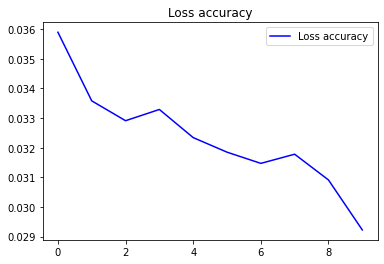

<Figure size 432x288 with 0 Axes>

In [113]:
# Plot the loss accuracies for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Loss accuracy')
plt.title('Loss accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [114]:
pred = model.predict(val_array)
test_result = scale.inverse_transform(pred)
real = scale.inverse_transform(val_labels)

In [116]:
import math
from sklearn.metrics import mean_squared_error
print("Prediction Result")
print(test_result[:20])
print("Actual")
print(real[:20])
# testScore = math.sqrt(mean_squared_error(test_result, real))
# print('Test Score: %.2f RMSE' % (testScore))

Prediction Result
[[ 61.59007 ]
 [ 63.222492]
 [ 64.77699 ]
 [ 69.01393 ]
 [ 57.974953]
 [ 56.306812]
 [ 63.549427]
 [ 50.85866 ]
 [ 60.424023]
 [103.54846 ]
 [ 57.40825 ]
 [ 72.96999 ]
 [ 60.499317]
 [ 56.510864]
 [ 55.248787]
 [ 44.274178]
 [ 76.685745]
 [ 82.551834]
 [ 92.65075 ]
 [ 46.989502]]
Actual
[[ 59.]
 [ 29.]
 [ 29.]
 [ 74.]
 [ 74.]
 [ 52.]
 [ 39.]
 [145.]
 [138.]
 [109.]
 [101.]
 [278.]
 [ 21.]
 [ 21.]
 [ 21.]
 [ 79.]
 [ 49.]
 [ 49.]
 [ 49.]
 [ 64.]]
